# ch06/optimizer_compare_naive.py

학습 관련 기술들

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import sys, os
sys.path.append('/content/drive/MyDrive/Colab Notebooks/밑바닥부터시작하는')
sys.path.append(os.pardir)
sys.path.append('/content/drive/MyDrive/Colab Notebooks/밑바닥부터시작하는/ch06')
sys.path.append('/content/drive/MyDrive/Colab Notebooks/밑바닥부터시작하는/common')
sys.path.append('/content/drive/MyDrive/Colab Notebooks/밑바닥부터시작하는/dataset')
import numpy as np

Mounted at /content/drive


확률적 경사 하강법(SGD)

In [ ]:
class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr

    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]

In [ ]:
## SGD 개선1 ##
class Momentum:
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None

    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)

        for key in params.keys():
            self.v[key] = self.momentum*self.v[key] - self.lr*grads[key]
            params[key] += self.v[key]

# v: 물체의 속도

In [ ]:
## SGD 개선2 ##
class AdaGrad:
    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None

    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)

        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

In [ ]:
## SGD 개선3 ##
# Adam: Momentum + AdaGrad

# ch06/weight_init_activation_histogram.py

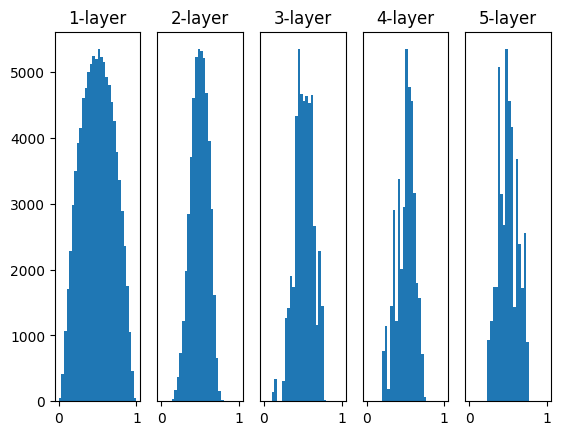

In [ ]:
## 은닉층의 활성화값 분포
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# def ReLU(x):
#     return np.maximum(0, x)


# def tanh(x):
#     return np.tanh(x)

x = np.random.randn(1000, 100) #1000개의 데이터
node_num = 100 #각 은닉층의 노드(뉴런) 수
hidden_layer_size = 5  #은닉층 갯수
activations = {}  #이곳에 활성화 결과(활성화값) 저장

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    #w = np.random.randn(node_num, node_num) * 1
    #w = np.random.randn(node_num, node_num) * 0.01
    w = np.random.randn(node_num, node_num) / np.sqrt(node_num) #Xavier초기값 이용

    a = np.dot(x, w)
    z = sigmoid(a)
    # z = ReLU(a)
    # z = tanh(a)

    activations[i] = z

# 히스토그램 그리기
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    # plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()


# ch06/overfit_weight_decay.py

In [ ]:
import os
import sys

sys.path.append(os.pardir)
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 오버피팅을 제현하기 위해 학습데이터 수 줄임
x_train = x_train[:300]
t_train = t_train[:300]

#훈련 수행.
network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10)
optimizer = SGD(lr=0.01) #학습률이 0.01인 SGD로 매개변수 갱신

max_epochs = 201
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0

for i in range(1000000000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        # print("epoch:" + str(epoch_cnt) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc))

        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break

#그래프로 그리기
# markers = {'train': 'o', 'test': 's'}
# x = np.arange(max_epochs)
# plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
# plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
# plt.xlabel("epochs")
# plt.ylabel("accuracy")
# plt.ylim(0, 1.0)
# plt.legend(loc='lower right')
# plt.show()


In [ ]:
## 가중치 감소 Weight decay ##
'''
  학습과정 중 큰 가중치 -> 상응하는 큰 패널티 부과 -> 오버피팅 억제
'''

# ch06/overfit_dropout.py

In [ ]:
 #DropOut: 가중치 감소만으로 부족할때
class Dropout:
    def __init__(self, dropout_ratio=0.5):
        self.dropout_ratio = dropout_ratio
        self.mask = None

    def forward(self, x, train_flg=True):
        if train_flg:
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio  # 비교후 큰원소만 True로.
            return x * self.mask
        else:
            return x * (1.0 - self.dropout_ratio)

    #ReLU와 동일
    def backward(self, dout):
        return dout * self.mask

# ch06/hyperparameter_optimization.py

적절한 하이퍼 파라미터 값 찾기

In [ ]:

import sys, os
sys.path.append(os.pardir)
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net import MultiLayerNet
from common.util import shuffle_dataset
from common.trainer import Trainer

(x_train, t_train), (x_test, t_test) = load_mnist()

#훈련 데이터를 뒤섞는다.
x_train, t_train = shuffle_dataset(x_train, t_train)

#20%를 검증데이터로 분할
validation_rate = 0.20
validation_num = int(x_train.shape[0] * validation_rate)

x_val = x_train[:validation_num]
t_val = t_train[:validation_num]
x_train = x_train[validation_num:]
t_train = t_train[validation_num:]


In [ ]:
# 하이퍼파라미터 최적화 구현하기
weight_decay = 10 ** np.random.uniform(-8, -4)
lr = 10 ** np.random.uniform(-6, -2)